In [210]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.9.11 pynndescent==0.5.8


# Load Spectrum Data and Embedding

In [211]:
adata = sc.read("specfull.h5ad")

site = []
for x in adata.obs["author_sample_id"]:
    if "BOWEL" in x:
        site.append("BOWEL")
    else:
        site.append("ADNEXA")
adata.obs["site"] = site

adata.obs["patient"] = [x.split("_")[0] for x in adata.obs["author_sample_id"]]
len(set(adata.obs["patient"]))

/Users/ceglian/gvenv/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


26

In [212]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [213]:
ct = []
for x in adata.obs["author_cell_type"]:
    if x in ["Dendritic.cell","Mast.cell","Monocyte"]:
        ct.append("Myeloid")
    elif x in ["B.cell","Plasma.cell"]:
        ct.append("B-Plasma")
    else:
        ct.append(x)
adata.obs["celltype"] = ct

In [214]:
sc.pp.highly_variable_genes(adata,n_top_genes=1000,flavor="seurat_v3")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [215]:
kgenes = []
for x,y in zip(adata.var["highly_variable"],adata.var.index.tolist()):
    if str(x) == "True" or y in amarkers:
        kgenes.append(y)
print(len(kgenes))



1019


In [216]:
adata = adata[:,kgenes]


In [217]:
dataset = GeneVectorDataset(adata)

Loading Expression.
Indexing expression.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25025495/25025495 [00:14<00:00, 1691878.70it/s]


Finished.


In [219]:
embed = GeneEmbedding("spectrum_all_samples.vec", dataset,vector="average")

Loading average of 1st and 2nd weights.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:00<00:00, 3465286.24it/s]


normalizing counts per cell
    finished (0:00:00)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25025495/25025495 [00:59<00:00, 424032.62it/s]


Generating Cell Vectors.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270833/270833 [00:11<00:00, 23835.21it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:02)


/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


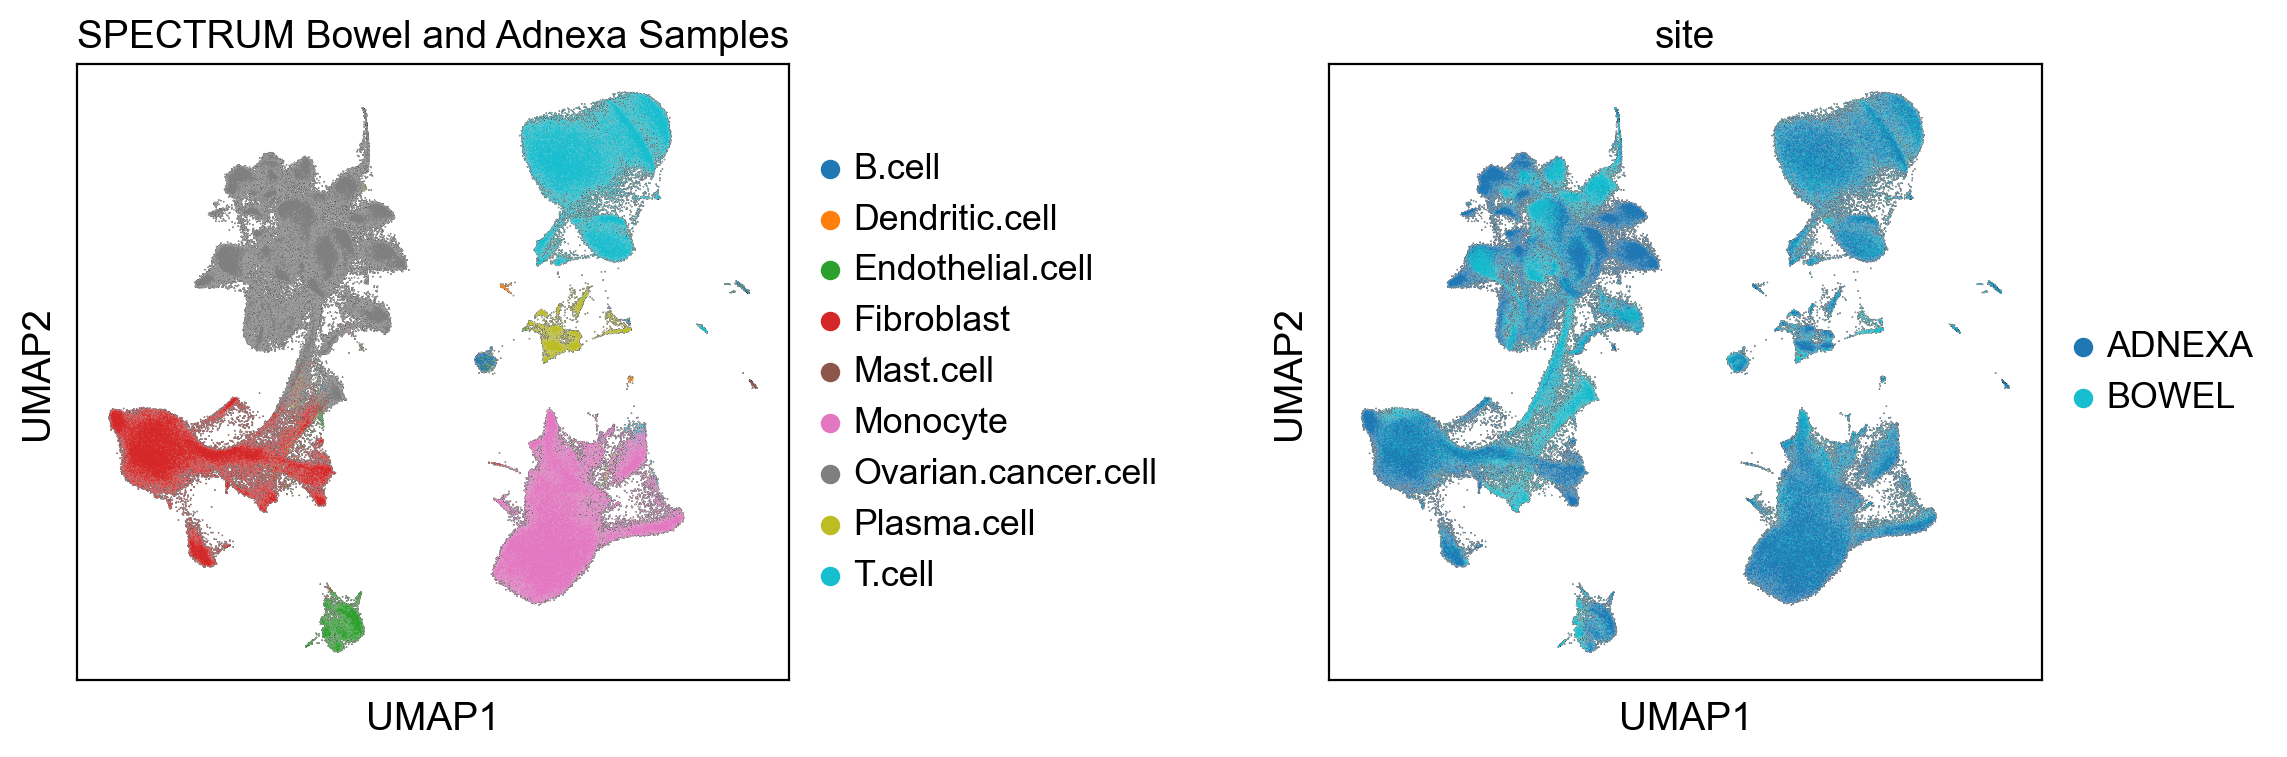

In [220]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
sc.pl.umap(adata,palette="tab10",color=["author_cell_type","site"],
           title=["SPECTRUM Bowel and Adnexa Samples"],add_outline=True,wspace=0.6)

In [221]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [225]:
def phenotype_probability(self, adata, up_phenotype_markers, down_phenotype_markers, target_col="genevector"):
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    adata = adata[list(self.data.keys())]
    probs = dict()
    for pheno, markers in up_phenotype_markers.items():
        dists = []
        vector = self.embed.generate_vector(markers)
        if pheno in down_phenotype_markers:
            for g in down_phenotype_markers[pheno]:
                dvector = self.embed.generate_vector(g)
                offset = numpy.subtract(dvector, vector)
                vector = numpy.add(vector,offset)
        ovecs = []
        for oph, ovec in up_phenotype_markers.items():
            if oph != pheno:
                ovec = self.embed.generate_vector(ovec)
                ovecs.append(ovec)
        aovec = numpy.mean(ovecs,axis=0)
        vector = numpy.subtract(vector,aovec)

        for x in tqdm.tqdm(adata.obs.index):
            dist = 1.0 - distance.cosine(mapped_components[x],vector)
            dists.append(dist)
        probs[pheno] = dists
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = list(zip(*distribution))
    classif = []
    probabilities = []
    scaler = StandardScaler()
    probabilities = softmax(scaler.fit_transform(numpy.array(distribution)),axis=1)
    for ct in probabilities:
        assign = celltypes[numpy.argmax(ct)]
        classif.append(assign)
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    return adata

In [226]:
ct = []
for x in adata.obs['author_cell_type']:
    if x in ["Dendritic.cell","Mast.cell"]:
        ct.append("Other")
    else:
        ct.append(x)
adata.obs["celltype"] = ct

In [228]:
import pandas
markers = cembed.get_predictive_genes(adata,"author_cell_type",n_genes=20)
pandas.DataFrame.from_dict(markers).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Ovarian.cancer.cell,SLPI,SCGB2A1,MUC16,KRT7,EPCAM,NEUROG1,WFDC2,KRT8,MAL2,CP,CLDN3,CTXN1,MIEN1,ERBB2,UQCC3,KLK6,TM4SF1,TACSTD2,KRT19,KLK7
Fibroblast,COL1A2,LUM,STMN2,BGN,COL6A2,COL3A1,CCDC80,AEBP1,COL5A2,COL6A1,CALD1,COL5A1,SPARC,COL12A1,PTGDS,DCN,C1R,MMP11,THBS2,RARRES2
T.cell,CD3D,GZMA,CD3G,CD2,TRBC1,CD3E,BATF,CD52,TIGIT,IL17F,CTSW,CTLA4,TRAC,CD27,ACKR1,PRF1,GZMK,CD8A,EMCN,KLRB1
Endothelial.cell,PLVAP,RAMP2,RERGL,VWF,ADGRL4,CLEC14A,CDH5,LILRA4,PCDH17,CD34,RAMP3,SLN,MCEMP1,S100A12,DKK4,PNPLA1,HSPG2,CXORF36,COL4A1,FLT1
Monocyte,AIF1,C1QA,OLR1,C1QC,FCGR3A,C1QB,TYROBP,FCER1G,CD163,PLEK,IL1B,VSIG4,CD300LG,CCL3L1,ITGAM,GPR183,LYZ,BCL2A1,CCL3,FBP1
Dendritic.cell,GPR183,SLC16A10,GZMB,CLEC5A,CDH5,TCL1A,FCER1G,MPEG1,TYROBP,PLD4,AIF1,APLNR,ESAM,OLR1,PLCXD3,NKG7,IRF8,DNAH12,C5AR2,CLEC4E
B.cell,CD79A,POU2AF1,DSC1,LY6H,WDR38,IGHM,MS4A1,IGHA1,FAM81B,CST2,TCHH,CALB1,FGFBP2,CCL17,TRAC,CD163L1,CALY,EPYC,PTGS2,CASC1
Plasma.cell,IGHG2,IGHG3,IGHG1,IGLC3,IGLC2,IGHG4,MUCL3,MZB1,IGKC,IGHA1,BPIFB1,IGHGP,HES5,IGFL1,CALML3,KRT4,JCHAIN,SLC6A14,MUCL1,PLPPR3
Mast.cell,MS4A2,IL13,CPA3,HDC,KRT1,SLC18A2,CCL1,TPSAB1,FCGBP,APOD,CENPA,CTSG,ADCYAP1,SCG2,HIST1H1B,HPGDS,CD79A,KIT,RRM2,GATA2


In [230]:
annotated_adata = phenotype_probability(cembed, adata,markers,negative_markers)
prob_cols = [x for x in annotated_adata.obs.columns.tolist() if "Pseudo-probability" in x]

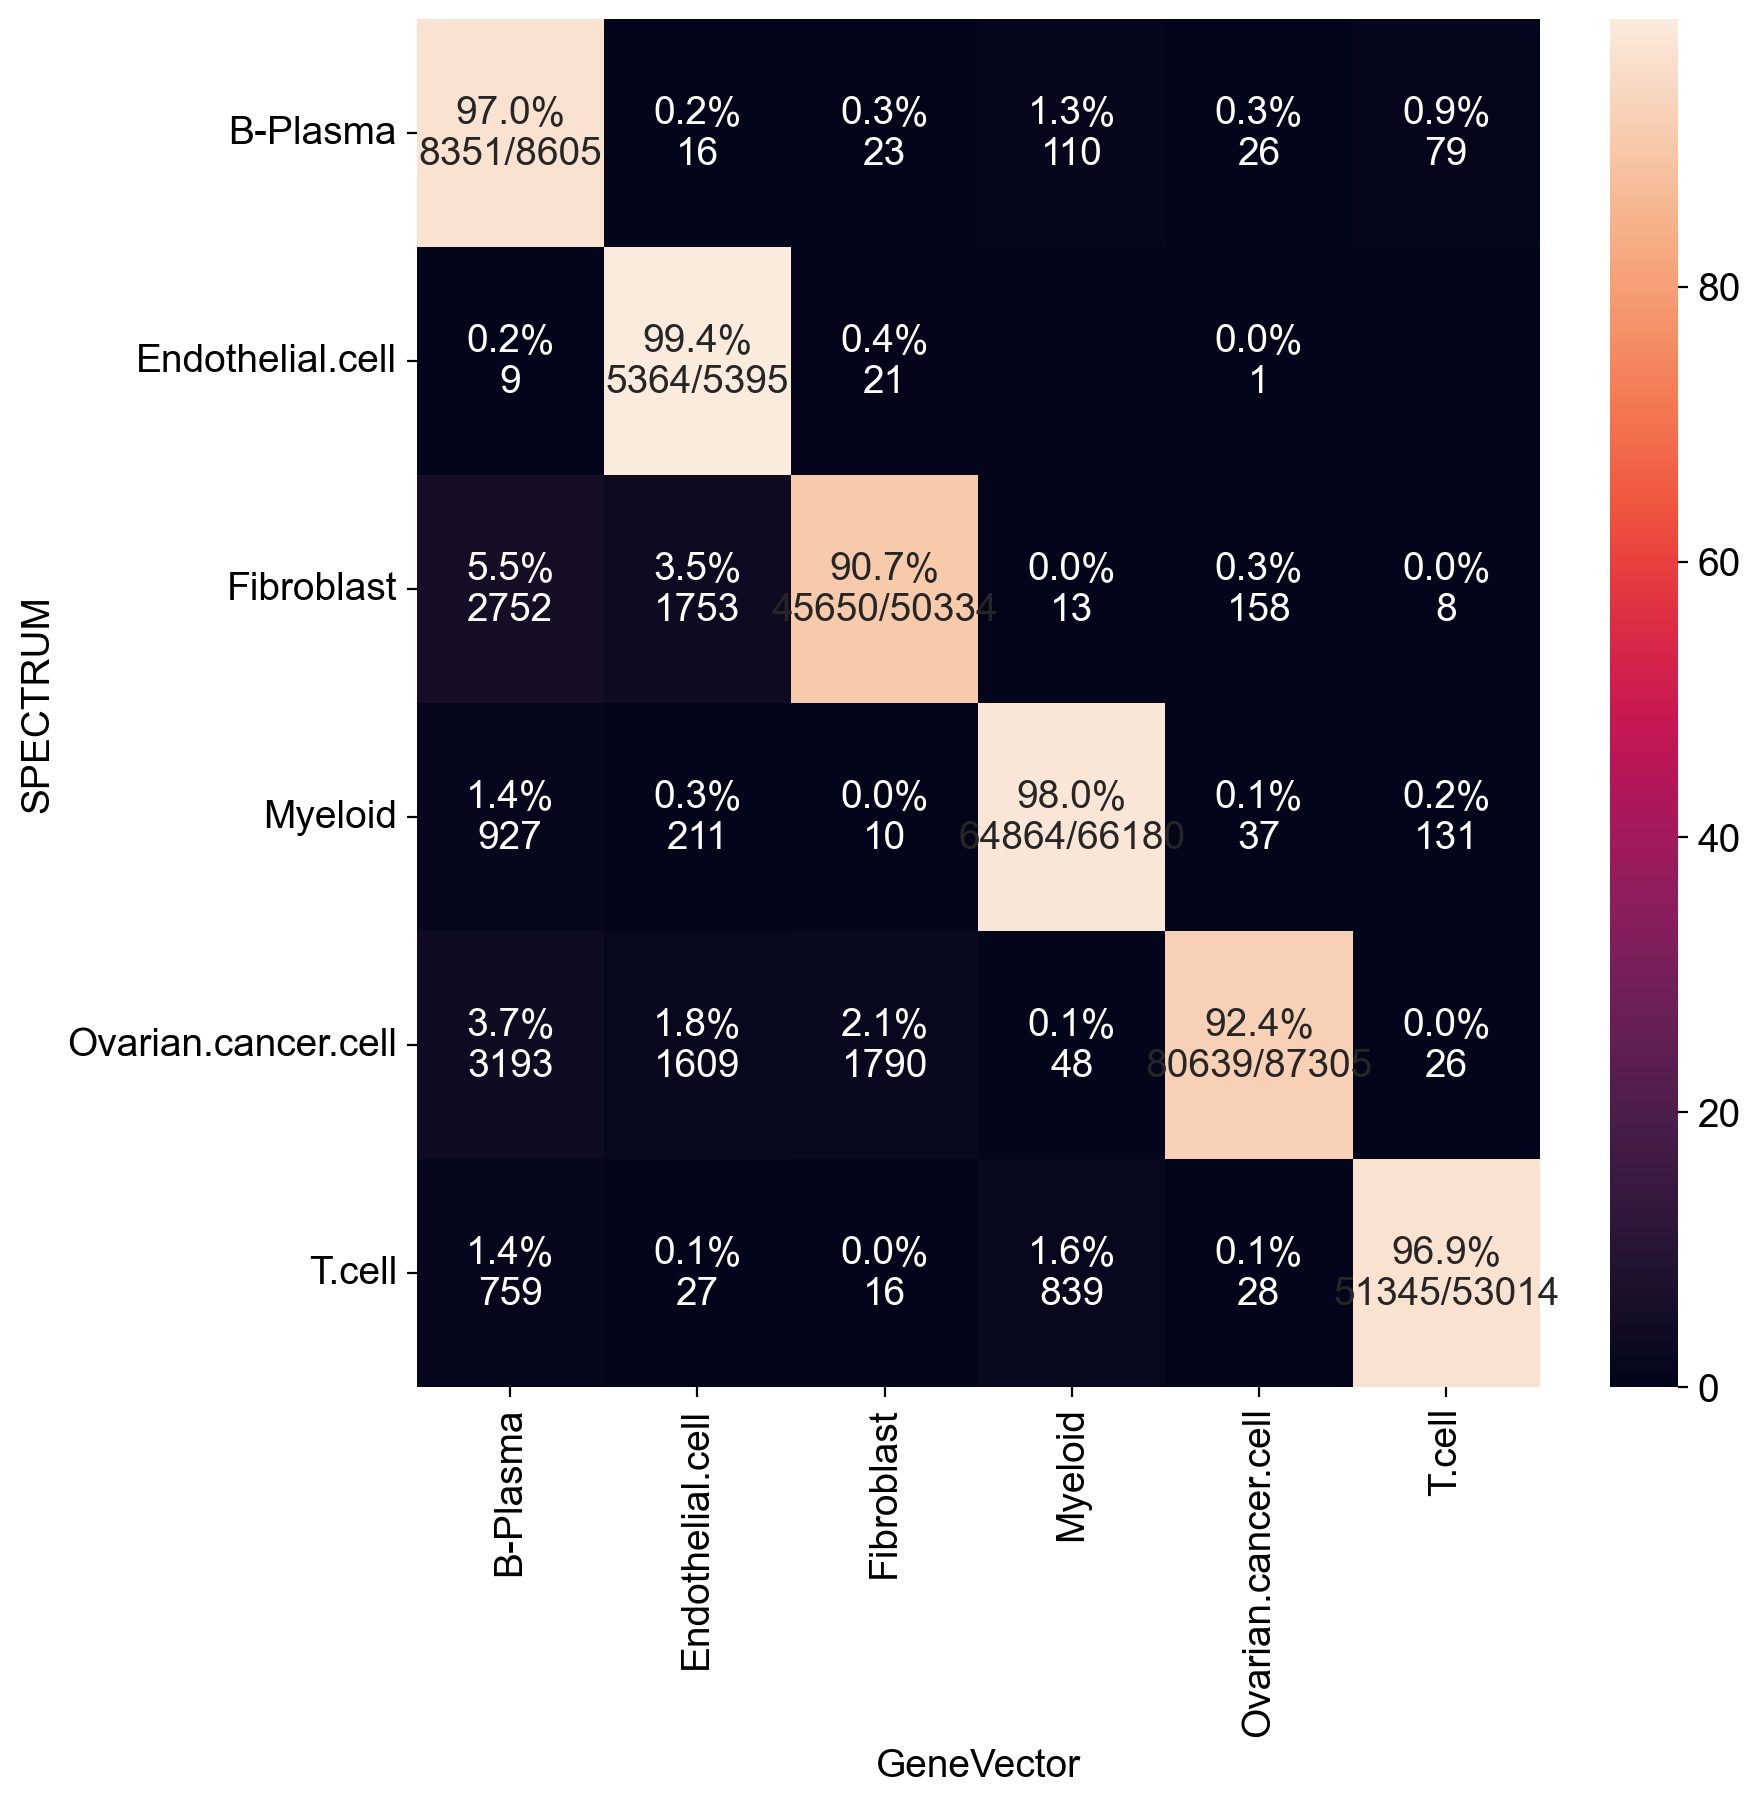

In [231]:
ct = []
for x in annotated_adata.obs["genevector"]:
    if x in ["Dendritic.cell","Mast.cell","Monocyte"]:
        ct.append("Myeloid")
    elif x in ["B.cell","Plasma.cell"]:
        ct.append("B-Plasma")
    else:
        ct.append(x)
annotated_adata.obs["genevector"] = ct

ct = []
for x in annotated_adata.obs["author_cell_type"]:
    if x in ["Dendritic.cell","Mast.cell","Monocyte"]:
        ct.append("Myeloid")
    elif x in ["B.cell","Plasma.cell"]:
        ct.append("B-Plasma")
    else:
        ct.append(x)
annotated_adata.obs["celltype"] = ct

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

gv_ct = annotated_adata.obs["genevector"].tolist()
ca_ct = annotated_adata.obs["celltype"].tolist()
def plot_cm(y_true, y_pred, figsize=(9,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'SPECTRUM'
    cm.columns.name = 'GeneVector'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("/Users/ceglian/spectrum_acc.pdf")

plot_cm(ca_ct,gv_ct)

